In [ ]:

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/anhECG')
os.listdir('/content/drive/MyDrive/anhECG')
# infor of GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Fri Feb 26 08:41:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

predicting....
predicting test data....


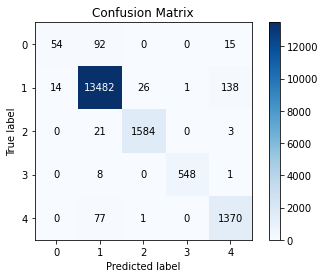

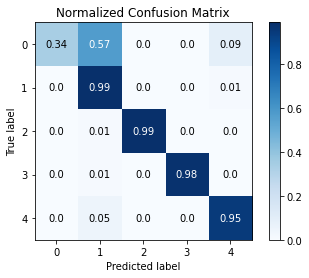

0.9772297103527388
predicting train data....


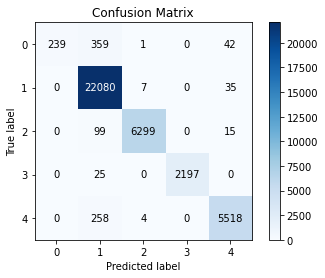

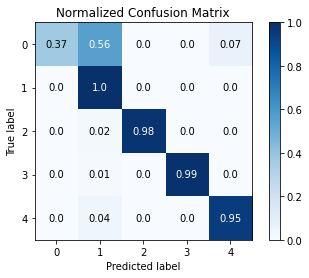

0.9772715046532896
0.9772297143936157
0.9637150764465332


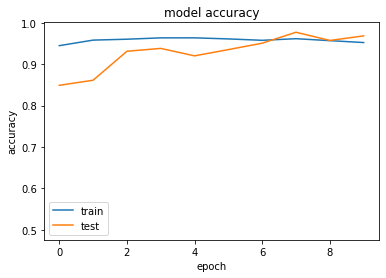

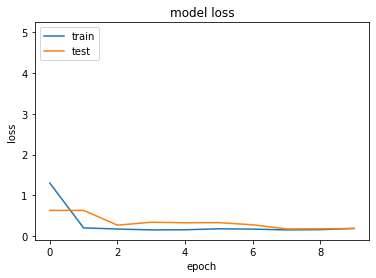

In [ ]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from keras.models import  load_model
import time
import tensorflow as tf

# Khai báo
X_train=[]
y_train=[]
X_test=[]
y_test=[]

filename1="model_thu.h5"
filename2='my_history_thu.npy'
#nepochs=100 #ndrop = 0.5, 0.7 #size=64 sai lop thu 1
# nepochs=100 ndrop = 0.4 size=64 dat 97.9% nhung lop 1 thap qua 40% ddax chay lai van sai
# nepochs=50 ndrop = 0.4 size=32 sai lop 1
# nepochs=50 ndrop = 0.5 size=32 sai lop 1
# nepochs=50 ndrop = 0.3 size=32  dat 96,38% phaan lop dep
# nepochs=50 ndrop = 0.3 size=64  dat 95,83% phaan lop dep, 96,05
# nepochs=50 ndrop = 0.4 size=16 phaan lowps sai 
# nepochs=50 ndrop = 0.4 size=128, 256 chi dat 96% 95%
# nepochs=50 ndrop = 0.5 size=512,256 rất thấp, 128- 95%
# nepochs=50 ndrop = 0.6 size=64 
# Quyet dinh nepochs=100 ndrop = 0.4 size=64, lấy % tùy chon đã luu
# adagrad tốt
nepochs=100
ndrop = 0.5
size=64

X_train = np.load("xtrain.npy")
y_train = np.load("ytrain.npy")
X_test = np.load("xtest.npy")
y_test = np.load("ytest.npy")

encoder = LabelBinarizer()
y_train =encoder.fit_transform(y_train)
y_test =encoder.fit_transform(y_test)

for (i,lab) in enumerate(encoder.classes_):
    print("{}.{}".format(i+1,lab))

base_model = VGG16(input_shape=(128,128,3),weights='imagenet', include_top=False)
    # Dong bang cac layer
for layer in base_model.layers:
        layer.trainable = False
    # Them cac layer FC va Dropout
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
#x = BatchNormalization()(x) không tăng độ chính xác
x = Dropout(ndrop)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
#x = BatchNormalization()(x)
x = Dropout(ndrop)(x)
x = Dense(5, activation='softmax', name='predictions')(x)
    # Compile
my_model = Model(base_model.input, x)
filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

my_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
start = time.time()
history = my_model.fit(
  X_train,y_train,
  validation_data=(X_test,y_test),
  epochs=nepochs,verbose=2,#shuffle=True, 
  batch_size=size,
  callbacks=callbacks_list
)

my_model.save(filename1)
np.save(filename2, history.history)
print("Thoi gian chay", time.time()-start,"seconds")




model = tf.keras.models.load_model('/content/drive/MyDrive/anhECG/weights-08-0.98.hdf5')
Xtest=[]
ytest=[]
width,height=128,128
  
# Đọc dữ liệu
Xtest = np.load("xtest.npy")
ytest = np.load("ytest.npy")
print("predicting....")
pre = model.predict(Xtest)
encoder = LabelBinarizer()
ytest=encoder.fit_transform(ytest)
yhat= np.argmax(pre,axis=1)
ytest1 = np.argmax(ytest,axis=1)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#print(confusion_matrix(yhat,ytest1))
# Vẽ chuẩn bị
!pip install scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(ytest1, yhat, normalize=False)
skplt.metrics.plot_confusion_matrix(ytest1, yhat, normalize=True)
print("predicting test data....")
plt.show()
print(accuracy_score(ytest1, yhat))


#====================================
Xtest = np.load("xtrain.npy")
ytest = np.load("ytrain.npy")

pre = model.predict(Xtest)
encoder = LabelBinarizer()
ytest=encoder.fit_transform(ytest)
yhat= np.argmax(pre,axis=1)
ytest1 = np.argmax(ytest,axis=1)
#from sklearn.metrics import confusion_matrix
#print(confusion_matrix(yhat,ytest1))
# Vẽ chuẩn bị
#!pip install scikit-plot
#import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(ytest1, yhat, normalize=False)
skplt.metrics.plot_confusion_matrix(ytest1, yhat, normalize=True)
print("predicting train data....")
plt.show()
print(accuracy_score(ytest1, yhat))


history1= np.load(filename2,allow_pickle='True').item()

print(np.max(history1['val_accuracy']))
print(np.max(history1['accuracy']))
# summarize history for accuracy

plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.plot([0.5])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()
# summarize history for loss

plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.plot([5.0])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()